In [1]:
#!/usr/bin/python

import numpy as np
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib as mp
import datetime
import os
import warnings
warnings.filterwarnings('ignore')

import scipy.io

import sys
sys.path.append('/home2/datahome/cdemarez/MODULES_PY') 

from tools import *

from croco_tools_cdm import *
from plot_tools import *

import matplotlib.patches as patches

In [2]:
#path a changer pour differents run

path1 = '/home2/datawork/cdemarez/Needs/V1'
#path2 = '/home2/scratch/cdemarez/LEEWA/final'
#path2 = '/home2/scratch/cdemarez/LEEWA/finalv2'
path2='/home/datawork-lops-oh/meddle/cdemarez/STAGE_M2/final_v2'

In [3]:
#load parameters of the simulation
h,lon,lat,mask,f,time_ini,pm,pn,angle=load_param_simulation(path1)

('date du fichier ini:', datetime.date(2016, 3, 20))


## Load Leewa

In [5]:
def compute_div_strain(u,v,pm_u,pn_u):

    dxU_tmp=(u[:,1:]*pm_u[:,1:])- (u[:,:-1]*pm_u[:,:-1])
    dyV_tmp=(v[1:,:]*pn_u[1:,:])- (v[:-1,:]*pn_u[:-1,:])
    dxV_tmp=(v[:,1:]*pm_u[:,1:])- (v[:,:-1]*pm_u[:,:-1])
    dyU_tmp=(u[1:,:]*pn_u[1:,:])- (u[:-1,:]*pn_u[:-1,:])

    dxU=0.5*(dxU_tmp[1:,:]+dxU_tmp[:-1,:])
    dyV=0.5*(dyV_tmp[:,1:]+dyV_tmp[:,:-1])
    dxV=0.5*(dxV_tmp[1:,:]+dxV_tmp[:-1,:])
    dyU=0.5*(dyU_tmp[:,1:]+dyU_tmp[:,:-1])


    D=dxU+dyV #divergence
    S1=dxU-dyV #Stretching
    S2=dxV+dyU #Shear
    S=np.sqrt(S1**2+S2**2) #Strain 
    
    return D,S,dxU,dyV,dxV,dyU


In [6]:
## load the simulation output



path_u='./'

file='u_v_516.nc'
ncfile=path_u+file
nc = Dataset(ncfile)
u= nc.variables['u'][0,:,:]
v= nc.variables['v'][0,:,:]
u,v=rotate_uv(u,v,angle[1:,1:])
nc.close()





pm_u_tmp=0.5*(pm[1:,:]+pm[:-1,:])
pm_u=0.5*(pm_u_tmp[:,1:]+pm_u_tmp[:,:-1])

pn_u_tmp=0.5*(pn[1:,:]+pn[:-1,:])
pn_u=0.5*(pn_u_tmp[:,1:]+pn_u_tmp[:,:-1])


lon_dxu=lon[1:-1,1:-1]
lat_dxu=lat[1:-1,1:-1]

D,S,dxU,dyV,dxV,dyU=compute_div_strain(u,v,pm_u,pn_u)

rough=(dxU+dyV+dxV+dyU)


"\nplt.figure(figsize=(15,15))\n\nplt.pcolormesh(lon_dxu,lat_dxu,dxU+dyV+dxV+dyU,cmap='binary',vmin=-0.0001,vmax=0.0001)\nplt.colorbar()\nplt.show()\n\nplt.figure(figsize=(15,15))\n\nplt.pcolormesh(lon_dxu,lat_dxu,dxU_filt+dyV_filt+dxV_filt+dyU_filt,cmap='binary',vmin=-0.0001,vmax=0.0001)\nplt.colorbar()\nplt.show()\n"

## Load sat data

In [7]:
path_data='./'

file='jonathan_20100401_terra.mat'

mat = scipy.io.loadmat(path_data+file)
print(mat.keys())
lat_terra=mat['Lat'][:]
lon_terra= mat['Lon'][:]
dataH= mat['dataH'][:]
data= mat['data'][:]
mat=[]

terra=dataH/data
data=[]
dataH=[]


file='jonathan_20100401_aqua.mat'

mat = scipy.io.loadmat(path_data+file)
print(mat.keys())
lat_aqua=mat['Lat'][:]
lon_aqua= mat['Lon'][:]
dataH= mat['dataH'][:]
data= mat['data'][:]
mat=[]

aqua=dataH/data
data=[]
dataH=[]


file='jonathan_20100401_meris.mat'

mat = scipy.io.loadmat(path_data+file)
print(mat.keys())
lat_meris=mat['Lat'][:]
lon_meris= mat['Lon'][:]
dataH= mat['dataH'][:]
data= mat['data'][:]
mat=[]

meris=dataH/data
data=[]
dataH=[]

['dataH', 'Lon', '__header__', '__globals__', 'Lat', '__version__', 'data']
['dataH', 'Lon', '__header__', '__globals__', 'Lat', '__version__', 'data']
['dataH', 'Lon', '__header__', '__globals__', 'Lat', '__version__', 'data']


## do lowpass

In [66]:
corners_lil=[-79,31,-78,32] #the original one : ok
#corners_lil=[-79.5,30.8,-77.7,32.18]
corners_Fr=[-79.5,30.8,-77.7,32.18]

In [26]:
#extract only the lil area

def take_lil_i(lon,lat,var,corners_lil,dxi):
    map = Basemap(llcrnrlon=corners_lil[0],llcrnrlat=corners_lil[1],urcrnrlon=corners_lil[2],urcrnrlat=corners_lil[3],
                  resolution='c',projection='merc')
    take=(lon>corners_lil[0])&(lon<corners_lil[2])&(lat>corners_lil[1])&(lat<corners_lil[3])
    lon_lil,lat_lil,var_lil=lon[take],lat[take],var[take]
    x,y=map(lon_lil,lat_lil)
    xi=np.arange(np.min(x),np.max(x),dxi)
    yi=np.arange(np.min(y),np.max(y),dxi)
    xi,yi=np.meshgrid(xi,yi)
    
    var_lil_i=griddata((x,y),var_lil,(xi,yi),method='cubic')
    
    return xi,yi,var_lil_i
    

In [27]:
def make_square(field):
    if np.argmax(field.shape)==0:
        tmp=(field.shape)[1]
        return np.copy(field[0:tmp,:])
    elif np.argmax(field.shape)==1:
        tmp=(field.shape)[0]
        return np.copy(field[:,0:tmp])

In [28]:
dxi=100

x_aqua_lil,y_aqua_lil,aqua_lil=take_lil_i(lon_aqua,lat_aqua,aqua,corners_lil,dxi)
x_aqua_lil=make_square(x_aqua_lil)
y_aqua_lil=make_square(y_aqua_lil)
aqua_lil=make_square(aqua_lil)

x_terra_lil,y_terra_lil,terra_lil=take_lil_i(lon_terra,lat_terra,terra,corners_lil,dxi)
x_terra_lil=make_square(x_terra_lil)
y_terra_lil=make_square(y_terra_lil)
terra_lil=make_square(terra_lil)

x_meris_lil,y_meris_lil,meris_lil=take_lil_i(lon_meris,lat_meris,meris,corners_lil,dxi)
x_meris_lil=make_square(x_meris_lil)
y_meris_lil=make_square(y_meris_lil)
meris_lil=make_square(meris_lil)

x_rough_lil,y_rough_lil,rough_lil=take_lil_i(lon_dxu,lat_dxu,rough,corners_lil,dxi)
x_rough_lil=make_square(x_rough_lil)
y_rough_lil=make_square(y_rough_lil)
rough_lil=make_square(rough_lil)

In [29]:
from scipy import signal

order=4

T_cut=2000 ##longueur d'onde en m
freq_cut=1./T_cut

dt=1. ##### le temps entre chaque fichier, normalement 1h
freq_ech=1./dxi

wn=freq_cut/(freq_ech/2.)

b, a = signal.butter(order, wn,btype='lowpass')

In [30]:
aqua_lil_filt=signal.filtfilt(b, a, np.where(np.isnan(aqua_lil),0,aqua_lil),axis=0 )
aqua_lil_filt=signal.filtfilt(b, a, aqua_lil_filt,axis=1 )
terra_lil_filt=signal.filtfilt(b, a, np.where(np.isnan(terra_lil),0,terra_lil),axis=0 )
terra_lil_filt=signal.filtfilt(b, a, terra_lil_filt,axis=1 )
meris_lil_filt=signal.filtfilt(b, a, np.where(np.isnan(meris_lil),0,meris_lil),axis=0 )
meris_lil_filt=signal.filtfilt(b, a, meris_lil_filt,axis=1 )
rough_lil_filt=signal.filtfilt(b, a, np.where(np.isnan(rough_lil),0,rough_lil),axis=0 )
rough_lil_filt=signal.filtfilt(b, a, rough_lil_filt,axis=1 )

# Recap plot with the topo and sst

In [32]:
nx1=2200
nx2=3000
ny1=1000
ny2=1700

ncfile='./A20100912010120.L3m_MO_SST_sst_4km.nc'
nc = Dataset(ncfile)
print(nc.variables.keys())
lon_sst=nc.variables['lon']
lat_sst=nc.variables['lat']
lon_sst,lat_sst=np.meshgrid(lon_sst,lat_sst)
lon_sst=lon_sst[ny1:ny2,nx1:nx2]
lat_sst=lat_sst[ny1:ny2,nx1:nx2]
sst=nc.variables['sst'][ny1:ny2,nx1:nx2]
nc.close()

[u'sst', u'qual_sst', u'lat', u'lon', u'palette']


In [36]:
#load aviso surface velocities
it_31=12 #to take the value on 31st march 2010
ncfile='./uv_surf_aviso.nc'
nc = Dataset(ncfile)
u_aviso= nc.variables['Grid_0001'][it_31,:,:].T
v_aviso= nc.variables['Grid_0002'][it_31,:,:].T
lon_aviso=nc.variables['NbLongitudes'][:]-360
lat_aviso=nc.variables['NbLatitudes'][:]
nc.close()
lon_aviso,lat_aviso=np.meshgrid(lon_aviso,lat_aviso)

corners_aviso=[-82,28,-76,34]
tmp1=lon_aviso<corners_aviso[2]
tmp2=lon_aviso>corners_aviso[0]
tmp3=lat_aviso<corners_aviso[3]
tmp4=lat_aviso>corners_aviso[1]
zone=tmp1&tmp2&tmp3&tmp4
u_aviso=u_aviso[zone]
v_aviso=v_aviso[zone]
lon_aviso=lon_aviso[zone]
lat_aviso=lat_aviso[zone]

In [34]:
from matplotlib import gridspec
plt.rcParams['axes.facecolor'] = 'gainsboro'
import matplotlib.patches as patches
import matplotlib as matplotlib

corners=[-82,28,-76,34]

minpl2=-0.1
maxpl2=0.1
bpl2=[-0.0001,0.0001]

map = Basemap(llcrnrlon=corners[0],llcrnrlat=corners[1],urcrnrlon=corners[2],urcrnrlat=corners[3],
                  resolution='i',projection='merc')

parallels = np.arange(20,40,2)
meridians=np.arange(-80,-60,2)

In [42]:
rast=True
#nshow=1
#nshow3=50
#nshow2=100

#plot the edge of leewa 
edge=3
border=np.copy(mask)
border[edge:-edge,edge:-edge]=np.nan


In [81]:
def plot_corners(corners_lil,name,col):
        tmpx,tmpy=map(corners_lil[::2],corners_lil[1::2])
        tmpx=np.array(tmpx)
        tmpy=np.array(tmpy)
        import matplotlib.patches as patches
        ##areas for small areas
        rect = patches.Rectangle((tmpx[0],tmpy[0]),
                             tmpx[1]-tmpx[0],tmpy[1]-tmpy[0],
                             linestyle='--',lw=2,
                             edgecolor=col,fill=None,alpha=0.8,
                             zorder=15)
        ax.add_patch(rect)
        
        t=ax.annotate(name, xy=((tmpx[1]+tmpx[0])/2.,(tmpy[1])+20e3),xycoords='data',ha='center', va='center',size=15,color=col,zorder=5000)
        #t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='k'),zorder=5000)

saving
showing


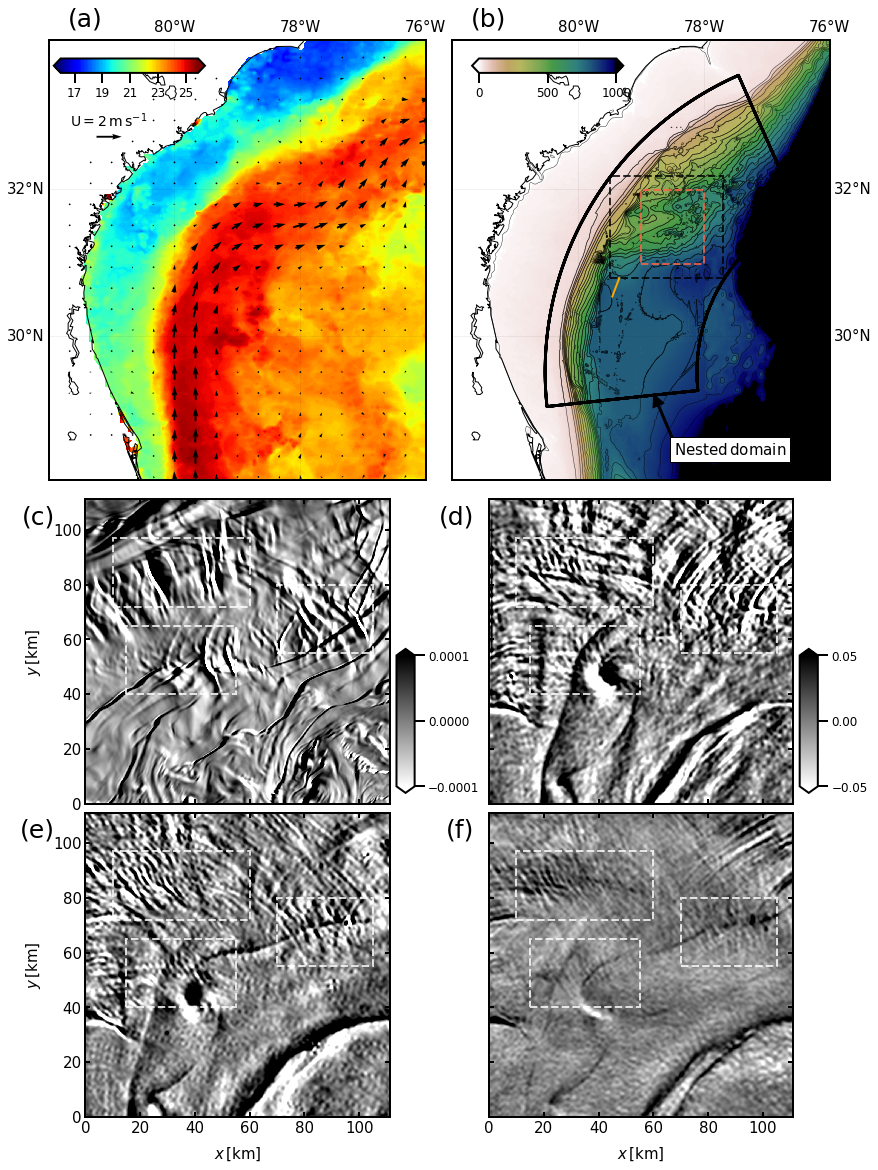

In [99]:
fig=plt.figure(figsize=(14,20))

gs = gridspec.GridSpec(7,4) 

for ip in range(6):
    if ip==0 or ip==1:
        ax=plt.subplot(gs[:3, 2*ip:(ip+1)*2],aspect='equal',facecolor='white')
    if ip==2:
        ax=plt.subplot(gs[3:5, :2],aspect='equal',facecolor='white')     
    if ip==3:
        ax=plt.subplot(gs[3:5, 2:],aspect='equal',facecolor='white')    
    if ip==4:
        ax=plt.subplot(gs[5:7, :2],aspect='equal',facecolor='white')   
    if ip==5:
        ax=plt.subplot(gs[5:7, 2:],aspect='equal',facecolor='white')    
    
    
    if ip==0:
        map.drawparallels(parallels,labels=[True,False,False,False],fontsize=15,linewidth=0.1,rasterized=False)
    elif ip==1 :
        map.drawparallels(parallels,labels=[False,True,True,True],fontsize=15,linewidth=0.1,rasterized=False)
   
    ax.spines['top'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=1) 
    if ip==0 or ip==1:
        map.drawcoastlines()
        ax.xaxis.set_label_position("top")
        ax.xaxis.set_ticks_position("top")
        map.drawmeridians(meridians,labels=[True,True,True,False],fontsize=15,linewidth=0.1,rasterized=False) 

    
    ## SST and velocity
    if ip==0:
        
        
        xmap,ymap=map(lon_sst,lat_sst)
        #pc=map.pcolormesh(xmap,ymap,sst,cmap='jet',vmin=18,vmax=26)
        pc=map.contourf(xmap,ymap,sst,np.arange(16,26,0.1),cmap='jet',extend='both')
        
        xmap, ymap = map(lon_aviso, lat_aviso)
        Q=plt.quiver(xmap,ymap,u_aviso,v_aviso,pivot='mid',scale=3000,width=5e-3)
        plt.quiverkey(Q, 0.16, 0.78,200,
             label=r'${\rm U=2\,m\,s^{-1}}$',fontproperties={'size':14},coordinates='axes')
        
        #xmap, ymap = map(lon_chabam, lat_chabam)
        #CS=map.contour(xmap,ymap,h_chabam,
        #               np.arange(0,800,200),colors='k',linewidths=1,alpha=1,zorder=4,rasterized=rast)
        #map.clabel(CS, inline=1, fontsize=10,colors='k')
    



    if ip==1:
        
        xmap, ymap = map(lon_chabam, lat_chabam)
        pc=map.pcolormesh(xmap,ymap,np.where(h_chabam>10,h_chabam,np.nan),rasterized=rast,vmin=0,vmax=1000,cmap='gist_earth_r')
        map.contour(xmap,ymap,h_chabam,
                       np.arange(5,1000,50),colors='k',linewidths=0.5,alpha=0.8,zorder=4,rasterized=rast)
        xmap, ymap = map(lon, lat)
        pc=map.pcolormesh(xmap,ymap,h,rasterized=rast,vmin=0,vmax=1000,cmap='gist_earth_r')#'RdYlBu'
        map.contour(xmap,ymap,h,
                       np.arange(5,1000,50),colors='k',linewidths=0.5,alpha=0.8,zorder=4,rasterized=rast)
        
        map.scatter(xmap,ymap,c=border,cmap='binary_r',s=2,zorder=5,rasterized=True)
        
        plot_corners(corners_lil,'','tomato')
        plot_corners(corners_Fr,'','k')
        
        #idealisez seamount
        lonsec1=[-79.46,-79.35]
        latsec1=[30.55,30.8]
        xmap_tmp, ymap_tmp = map(lonsec1,latsec1)
        map.plot(xmap_tmp, ymap_tmp,'-',color='orange',linewidth=2,zorder=50)
        

        x, y = map(-78.8, 29.2)
        x2, y2 = (20, -60)
        t=plt.annotate(r'${\rm Nested\, domain}$', xy=(x, y),  xycoords='data',
                        xytext=(x2, y2), textcoords='offset points',
                        color='k',size=15,
                        arrowprops=dict(color='k',width=2),
                        zorder=15,rasterized=False
                        )
        t.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='k'))
        

        
    if ip==2:
        minpl2=-0.1/2
        maxpl2=0.1/2
        bpl2=[-0.0001,0.0001]
        pc=plt.pcolormesh(x_rough_lil/1000.,y_rough_lil/1000.,rough_lil,cmap='binary',vmin=bpl2[0],vmax=bpl2[1],rasterized='True')
    elif ip==3:
        pc=plt.pcolormesh(x_aqua_lil/1000.,y_aqua_lil/1000.,aqua_lil_filt,cmap='binary',vmin=minpl2,vmax=maxpl2,rasterized='True')   
    elif ip==4:
        plt.pcolormesh(x_terra_lil/1000.,y_terra_lil/1000.,terra_lil_filt,cmap='binary',vmin=minpl2,vmax=maxpl2,rasterized='True')
    elif ip==5:
        plt.pcolormesh(x_meris_lil/1000.,y_meris_lil/1000.,meris_lil_filt,cmap='binary',vmin=minpl2,vmax=maxpl2,rasterized='True')

        
    if ip>1:
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        
        
        rect = patches.Rectangle((15,40),
                             40,25,
                             linestyle='--',lw=2,
                             edgecolor='w',fill=None,alpha=0.8,
                             zorder=15)
        ax.add_patch(rect)

        rect = patches.Rectangle((70,55),
                             35,25,
                             linestyle='--',lw=2,
                             edgecolor='w',fill=None,alpha=0.8,
                             zorder=15)
        ax.add_patch(rect)


        rect = patches.Rectangle((10,72),
                             50,25,
                             linestyle='--',lw=2,
                             edgecolor='w',fill=None,alpha=0.8,
                             zorder=15)
        ax.add_patch(rect)

        
        
        
        
    if ip==2 or ip==4:
        plt.ylabel(r'$y\, {\rm [km]}$',fontsize=15,labelpad=10,rotation=90)
    elif ip==3 or ip==5 :
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    if ip==4 or ip==5:
        plt.xlabel(r'$x\, {\rm [km]}$',fontsize=15,labelpad=10,rotation=0)
    elif ip==3 or ip==2 :
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        
        
        
   
    let=['(a)','(b)','(c)','(d)','(e)','(f)']
    if ip==0 or ip==1:
        t=plt.annotate(let[ip], xy=(0.05, 1.02),
                    xycoords='axes fraction',ha='left', va='bottom',
                    size=25)
    elif ip==2 or ip==4:
        t=plt.annotate(let[ip], xy=(-0.1, 0.98),
                    xycoords='axes fraction',ha='right', va='top',
                    size=25) 
    elif ip==3 or ip==5:
        t=plt.annotate(let[ip], xy=(-0.05, 0.98),
                    xycoords='axes fraction',ha='right', va='top',
                    size=25)

    
    ###colorbars
    if ip==0:
        cbar_ax = fig.add_axes([0.13, 0.85, 0.15, 0.01])
        cbar=fig.colorbar(pc, cax=cbar_ax,extend='both',orientation='horizontal',ticks=np.arange(11,30,2))
    elif ip==1:
        cbar_ax = fig.add_axes([0.545, 0.85, 0.15, 0.01])
        cbar=fig.colorbar(pc, cax=cbar_ax,extend='both',orientation='horizontal',ticks=np.arange(0,1500,500))
    elif ip==2:
        cbar_ax = fig.add_axes([0.47, 0.35, 0.018, 0.1])
        cbar=fig.colorbar(pc, cax=cbar_ax,extend='both',orientation='vertical',ticks=[bpl2[0],0,bpl2[1]])
    elif ip==3:
        cbar_ax = fig.add_axes([0.87, 0.35, 0.018, 0.1])
        cbar=fig.colorbar(pc, cax=cbar_ax,extend='both',orientation='vertical',ticks=np.arange(minpl2-1,maxpl2+0.1,0.05))
    #cbar.set_label(r'${\rm MODIS-aqua\, data\,2010/04/01}$', fontsize=15, 	rotation=0,labelpad=-60)
    #cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.set_offset_position('left')
    cbar.update_ticks()
    cbar.outline.set_linewidth(2)
    cbar_ax.tick_params(direction='out',width=2,length=10,labelsize=12)


    

        
plt.subplots_adjust(wspace=0.15,hspace=0.06)   


print("saving")
plt.savefig('./compare_obs_4.pdf',dpi=200,bbox_inches='tight')
print("showing")


plt.show()